In [1]:
import os
import numpy as np
import pandas as pd
from math import exp

# Load your saved dataset
DATA_PATH = os.path.expanduser("~/Desktop/bonds_project/data/market_panel.csv")
panel = pd.read_csv(DATA_PATH, index_col=0, parse_dates=True)
assert set(['y_2','y_5','y_10','y_30']).issubset(panel.columns), "Missing yield columns in panel."

# Use the latest fully-available observation
row = panel[['y_2','y_5','y_10','y_30']].dropna().iloc[-1]
print("As-of date:", panel[['y_2','y_5','y_10','y_30']].dropna().index[-1].date())
print(row)


As-of date: 2025-10-20
y_2     3.46
y_5     3.59
y_10    4.02
y_30    4.60
Name: 2025-10-20 00:00:00, dtype: float64


In [2]:
# We'll treat the FRED constant-maturity yields as spot (zero) rates (approximation).
# Build a curve dict in *decimals* (e.g., 0.0425 for 4.25%)
def build_curve_from_row(row):
    # row contains y_2, y_5, y_10, y_30 in PERCENT
    curve = {
        2.0:  row['y_2']  / 100.0,
        5.0:  row['y_5']  / 100.0,
        10.0: row['y_10'] / 100.0,
        30.0: row['y_30'] / 100.0,
    }
    return curve

CURVE_KEYS = [2.0, 5.0, 10.0, 30.0]

def interp_zero_rate(curve, t_years):
    """
    Piecewise-linear interpolation of zero rate r(t) as a function of maturity t (in years).
    If t < min key, extrapolate flat from first key; same for t > max key.
    """
    ks = np.array(sorted(curve.keys()))
    rs = np.array([curve[k] for k in ks])
    t = np.clip(t_years, ks.min(), ks.max())
    return float(np.interp(t, ks, rs))

def discount_factor_from_curve(curve, t_years, comp='cont'):
    """
    Discount factor using the interpolated zero rate.
    comp='cont' uses exp(-r t); comp='simple' uses 1/(1+r t) as a sanity alternative.
    """
    r = interp_zero_rate(curve, t_years)
    if comp == 'cont':
        return np.exp(-r * t_years)
    elif comp == 'simple':
        return 1.0 / (1.0 + r * t_years)
    else:
        raise ValueError("comp must be 'cont' or 'simple'")

curve = build_curve_from_row(row)
print("Curve (decimals):", curve)
print("DF(5y) =", discount_factor_from_curve(curve, 5.0))


Curve (decimals): {2.0: 0.0346, 5.0: 0.0359, 10.0: 0.04019999999999999, 30.0: 0.046}
DF(5y) = 0.8356879509431577


In [3]:
def bond_cashflows(maturity_years, coupon_rate, freq=2, face=100.0):
    """
    Return a list of (t, cf) for a plain-vanilla fixed coupon bond.
    maturity_years: e.g., 5.0
    coupon_rate: annual coupon in decimals (e.g., 0.03 for 3%)
    freq: payments per year (1, 2, 4). Default 2 = semiannual.
    face: redemption value (usually 100)
    """
    # Payment times in years: 1/f, 2/f, ..., maturity
    n = int(round(maturity_years * freq))
    times = np.arange(1, n + 1, dtype=float) / float(freq)
    # Make sure last time = maturity_years (minor rounding guard)
    times[-1] = maturity_years
    coupon_cf = coupon_rate * face / float(freq)
    cfs = np.full_like(times, coupon_cf, dtype=float)
    cfs[-1] += face
    return list(zip(times, cfs))

# Example
print(bond_cashflows(5.0, 0.03, freq=2)[:4], "... last:", bond_cashflows(5.0, 0.03, freq=2)[-1])


[(0.5, 1.5), (1.0, 1.5), (1.5, 1.5), (2.0, 1.5)] ... last: (5.0, 101.5)


In [4]:
def price_from_curve(curve, maturity_years, coupon_rate, freq=2, face=100.0, comp='cont'):
    cfs = bond_cashflows(maturity_years, coupon_rate, freq=freq, face=face)
    pv = 0.0
    for t, cf in cfs:
        df = discount_factor_from_curve(curve, t, comp=comp)
        pv += cf * df
    return pv

# Quick smoke test
p_5y = price_from_curve(curve, 5.0, 0.03, freq=2, face=100.0)
print("5y 3% bond price (from curve):", round(p_5y, 4))


5y 3% bond price (from curve): 97.1997


In [5]:
def price_from_ytm_flat(y, maturity_years, coupon_rate, freq=2, face=100.0):
    """
    Price using a *flat* yield y (decimal) with compounding at 'freq' per year.
    This is the textbook bond pricing under a flat YTM assumption.
    """
    n = int(round(maturity_years * freq))
    c = coupon_rate * face / float(freq)
    df = 1.0 / ((1.0 + y / float(freq)) ** np.arange(1, n+1))
    pv_coupons = c * df.sum()
    pv_redemption = face * df[-1]
    return pv_coupons + pv_redemption

def ytm_from_price(price, maturity_years, coupon_rate, freq=2, face=100.0, guess=0.04, tol=1e-10, maxit=100):
    """
    Solve for flat YTM y such that price_from_ytm_flat(y) = price.
    Newton-Raphson with a fallback to bisection if needed.
    """
    # Newton
    y = guess
    for _ in range(maxit):
        f = price_from_ytm_flat(y, maturity_years, coupon_rate, freq, face) - price
        # numerical derivative wrt y
        h = 1e-6
        f_up = price_from_ytm_flat(y + h, maturity_years, coupon_rate, freq, face) - price
        dfdy = (f_up - f) / h
        if abs(dfdy) < 1e-14:
            break
        step = f / dfdy
        y_new = y - step
        if abs(y_new - y) < tol:
            return max(y_new, -0.999)  # avoid pathological negatives
        y = y_new

    # Fallback: bisection on [0, 50%]
    lo, hi = 0.0, 0.50
    f_lo = price_from_ytm_flat(lo, maturity_years, coupon_rate, freq, face) - price
    f_hi = price_from_ytm_flat(hi, maturity_years, coupon_rate, freq, face) - price
    if f_lo * f_hi > 0:
        # Cannot bracket; return Newton's last
        return max(y, -0.999)
    for _ in range(200):
        mid = 0.5*(lo+hi)
        f_mid = price_from_ytm_flat(mid, maturity_years, coupon_rate, freq, face) - price
        if abs(f_mid) < tol:
            return mid
        if f_lo * f_mid <= 0:
            hi = mid; f_hi = f_mid
        else:
            lo = mid; f_lo = f_mid
    return mid

# Quick test: price ↔ ytm
p = price_from_ytm_flat(0.04, 5.0, 0.03, freq=2)
y = ytm_from_price(p, 5.0, 0.03, freq=2)
print("Flat-yield price:", round(p,4), "Recovered YTM:", round(y,6))


Flat-yield price: 95.5087 Recovered YTM: 0.04


In [6]:
def risk_parallel(curve, maturity_years, coupon_rate, freq=2, face=100.0, comp='cont', bump_bp=1.0):
    """
    Parallel-bump the entire curve by +/- bump_bp (basis points) and compute:
      - Duration (modified, finite-diff)
      - Convexity (finite-diff)
      - DV01 (dollar value per 1bp)
    Returns: (price0, duration, convexity, dv01)
    """
    bump = bump_bp / 10000.0  # convert bp -> decimal
    price0 = price_from_curve(curve, maturity_years, coupon_rate, freq=freq, face=face, comp=comp)

    # Up/down parallel bumps
    curve_up   = {k: v + bump for k, v in curve.items()}
    curve_down = {k: v - bump for k, v in curve.items()}

    p_up   = price_from_curve(curve_up,   maturity_years, coupon_rate, freq=freq, face=face, comp=comp)
    p_down = price_from_curve(curve_down, maturity_years, coupon_rate, freq=freq, face=face, comp=comp)

    # Modified duration via central difference
    duration = - (p_up - p_down) / (2.0 * bump * price0)

    # Convexity
    convexity = (p_up + p_down - 2.0 * price0) / (price0 * (bump ** 2))

    # DV01 (per 1bp)
    dv01 = - duration * price0 * 1e-4

    return price0, float(duration), float(convexity), float(dv01)

# Example
p0, dur, conv, dv01 = risk_parallel(curve, 5.0, 0.03, freq=2)
print("Parallel risk — P0:", round(p0,4), "Dur:", round(dur,4), "Conv:", round(conv,4), "DV01:", round(dv01,6))


Parallel risk — P0: 97.1997 Dur: 4.6741 Conv: 22.7867 DV01: -0.045432


In [7]:
def krdv01s(curve, maturity_years, coupon_rate, freq=2, face=100.0, comp='cont', bump_bp=1.0, keys=(2.0,5.0,10.0,30.0)):
    """
    Key-Rate DV01s: for each specified key maturity, bump ONLY that key by +1bp (others fixed),
    reprice, and compute DV01 at that key = (P_up - P0)/(-1bp)  (negative because price falls when rate rises).
    """
    bump = bump_bp / 10000.0
    P0 = price_from_curve(curve, maturity_years, coupon_rate, freq=freq, face=face, comp=comp)

    out = {}
    for k in keys:
        bumped = dict(curve)
        if k not in bumped:
            # if missing, insert by interpolating the current curve then bump that point
            bumped[k] = interp_zero_rate(curve, k)
        bumped[k] += bump

        P_up = price_from_curve(bumped, maturity_years, coupon_rate, freq=freq, face=face, comp=comp)
        # DV01 at key k: price sensitivity per 1bp at that node
        dv01_k = (P_up - P0) / (-bump_bp)  # per bp
        out[k] = float(dv01_k)
    return out

# Example
kr = krdv01s(curve, 5.0, 0.03, freq=2)
print("Key-Rate DV01s (per bp):", {k: round(v,6) for k,v in kr.items()})
print("Sum of KRDV01s (roughly ≈ parallel DV01):", round(sum(kr.values()), 6))


Key-Rate DV01s (per bp): {2.0: 0.00177, 5.0: 0.043651, 10.0: -0.0, 30.0: -0.0}
Sum of KRDV01s (roughly ≈ parallel DV01): 0.045421


In [8]:
def bond_spec(maturity_years, coupon_rate, freq=2, face=100.0, qty=1.0):
    return {"T": float(maturity_years), "c": float(coupon_rate), "f": int(freq), "F": float(face), "q": float(qty)}

def portfolio_price(curve, bonds, comp='cont'):
    total = 0.0
    for b in bonds:
        p = price_from_curve(curve, b["T"], b["c"], freq=b["f"], face=b["F"], comp=comp)
        total += b["q"] * p
    return total

def portfolio_parallel_risk(curve, bonds, comp='cont', bump_bp=1.0):
    P0 = portfolio_price(curve, bonds, comp=comp)
    bump = bump_bp / 10000.0
    up_curve   = {k: v + bump for k, v in curve.items()}
    down_curve = {k: v - bump for k, v in curve.items()}
    P_up   = portfolio_price(up_curve,   bonds, comp=comp)
    P_down = portfolio_price(down_curve, bonds, comp=comp)

    duration  = - (P_up - P_down) / (2.0 * bump * P0)
    convexity = (P_up + P_down - 2.0 * P0) / (P0 * (bump ** 2))
    dv01      = - duration * P0 * 1e-4
    return P0, float(duration), float(convexity), float(dv01)

def portfolio_krdv01s(curve, bonds, comp='cont', bump_bp=1.0, keys=(2.0,5.0,10.0,30.0)):
    P0 = portfolio_price(curve, bonds, comp=comp)
    out = {}
    for k in keys:
        bumped = dict(curve)
        if k not in bumped:
            bumped[k] = interp_zero_rate(curve, k)
        bumped[k] += bump_bp / 10000.0
        P_up = portfolio_price(bumped, bonds, comp=comp)
        dv01_k = (P_up - P0) / (-bump_bp)
        out[k] = float(dv01_k)
    return out


In [9]:
# Define three bonds: short/mid/long
b1 = bond_spec(2.0, 0.03, freq=2, face=100.0, qty=1.0)   # 2y 3%
b2 = bond_spec(5.0, 0.03, freq=2, face=100.0, qty=1.0)   # 5y 3%
b3 = bond_spec(10.0,0.03, freq=2, face=100.0, qty=1.0)   # 10y 3%
bonds = [b1,b2,b3]

# Single-bond analytics
for i,b in enumerate(bonds,1):
    p0, dur, conv, dv01 = risk_parallel(curve, b["T"], b["c"], freq=b["f"], face=b["F"])
    kr = krdv01s(curve, b["T"], b["c"], freq=b["f"], face=b["F"])
    print(f"\nBond {i}: T={b['T']}y, c={100*b['c']:.2f}%")
    print("  Price:", round(p0,4), "Duration:", round(dur,4), "Convexity:", round(conv,2), "DV01:", round(dv01,6))
    print("  KRDV01s per bp:", {k: round(v,6) for k,v in kr.items()}, " Sum:", round(sum(kr.values()),6))

# Portfolio analytics
P0, D_port, C_port, DV01_port = portfolio_parallel_risk(curve, bonds)
KR_port = portfolio_krdv01s(curve, bonds)

print("\n=== Portfolio ===")
print("Price:", round(P0,4), "Duration:", round(D_port,4), "Convexity:", round(C_port,2), "DV01:", round(DV01_port,6))
print("KRDV01s per bp:", {k: round(v,6) for k,v in KR_port.items()}, " Sum:", round(sum(KR_port.values()),6))



Bond 1: T=2.0y, c=3.00%
  Price: 99.0611 Duration: 1.9559 Convexity: 3.88 DV01: -0.019375
  KRDV01s per bp: {2.0: 0.019373, 5.0: -0.0, 10.0: -0.0, 30.0: -0.0}  Sum: 0.019373

Bond 2: T=5.0y, c=3.00%
  Price: 97.1997 Duration: 4.6741 Convexity: 22.79 DV01: -0.045432
  KRDV01s per bp: {2.0: 0.00177, 5.0: 0.043651, 10.0: -0.0, 30.0: -0.0}  Sum: 0.045421

Bond 3: T=10.0y, c=3.00%
  Price: 91.683 Duration: 8.6261 Convexity: 81.72 DV01: -0.079087
  KRDV01s per bp: {2.0: 0.00177, 5.0: 0.005419, 10.0: 0.071861, 30.0: -0.0}  Sum: 0.07905

=== Portfolio ===
Price: 287.9439 Duration: 4.9973 Convexity: 35.05 DV01: -0.143893
KRDV01s per bp: {2.0: 0.022913, 5.0: 0.04907, 10.0: 0.071861, 30.0: -0.0}  Sum: 0.143844


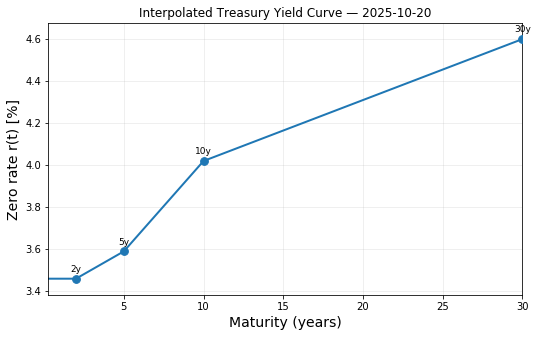

Saved to: /Users/oltimyrtaj/Desktop/bonds_project/figures/yield_curve_2025-10-20.png


In [12]:
# --- Plot the interpolated yield curve and save a slide-ready image ---

import os, numpy as np
import matplotlib.pyplot as plt

def plot_yield_curve(panel, as_of=None, t_min=0.25, t_max=30.0, outdir="~/Desktop/bonds_project/figures"):
    """
    Plots r(t) from the interpolated zero curve with node markers (2y/5y/10y/30y)
    and saves a high-DPI PNG for slides.
    """
    # pick a date with complete node data
    df_nodes = panel[['y_2','y_5','y_10','y_30']].dropna()
    if df_nodes.empty:
        raise ValueError("No rows with all four node yields.")
    if as_of is None:
        row = df_nodes.iloc[-1]
        as_of_date = df_nodes.index[-1].date()
    else:
        # choose the latest date <= as_of with full nodes
        row = df_nodes.loc[:as_of].iloc[-1]
        as_of_date = df_nodes.loc[:as_of].index[-1].date()

    curve = build_curve_from_row(row)  # uses functions defined earlier

    # maturities (years) and rates
    ts = np.linspace(t_min, t_max, 400)
    rs = np.array([interp_zero_rate(curve, t) for t in ts]) * 100.0  # to %

    # node points for scatter
    node_T = np.array([2.0, 5.0, 10.0, 30.0])
    node_y = np.array([row['y_2'], row['y_5'], row['y_10'], row['y_30']])

    # figure
    plt.figure(figsize=(8.5, 5))
    plt.plot(ts, rs, linewidth=2)
    plt.scatter(node_T, node_y, s=60, zorder=3)
    for T, y in zip(node_T, node_y):
        plt.annotate(f"{T:.0f}y", (T, y), textcoords="offset points", xytext=(0,7), ha="center", fontsize=9)

    plt.title(f"Interpolated Treasury Yield Curve — {as_of_date}")
    plt.xlabel("Maturity (years)", fontsize = 14)
    plt.ylabel("Zero rate r(t) [%]", fontsize = 14)
    plt.xlim(t_min, t_max)
    plt.grid(alpha=0.25)

    # save
    outdir = os.path.expanduser(outdir)
    os.makedirs(outdir, exist_ok=True)
    outpath = os.path.join(outdir, f"yield_curve_{as_of_date}.png")
    plt.savefig(outpath, dpi=300, bbox_inches="tight")
    plt.show()
    print("Saved to:", outpath)

# Run it for the latest available date
plot_yield_curve(panel)
